This notebook leverages the `pyiron_ising` module to perform size scaling tests for various mutation algorithms. 
Key parameters can be adjusted in the all-caps header.

In [1]:
QUEUE = 'cm'  # Remote queue to run on, set to None to use your local machine
CORES = 40  # How many cores to use, i.e. independent runs for each tests to get statistics
RUNTIME = 4*24*60*60 - 1  # 4 days in seconds, only used if QUEUE is not None
MAXSTEPS = int(1E6)  # The max number of iterations to use
# Dropping MAXSTEPS will allow you to run the calculations more quickly,
# But you may need to go through and shrink what sizes are used, otherwise many will fail to find a solution
CLEAN = False  # Delete all existing jobs and run from scratch
PLOT = True  # Whether to produce images from the data

# Setup

In [2]:
from pyiron_ising import Project, Model, Mutation, Chain1D, Square2D, Hex2D, BCC3D, Swap, Cluster
from typing import Type, List, Callable, Union
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
from functools import cached_property
from abc import ABC, abstractmethod


class Scaling(ABC):
    def __init__(
            self,
            project: Project,
            name: str,
            reps: List[int],
            min_like_neighbors=None,
            max_like_neighbors=None,
            n_steps: int = MAXSTEPS,
            n_print: int = MAXSTEPS,
            log_mutations: bool = False,
            cores: int = CORES if CORES is not None else 1,
            queue: Union[str, None] = QUEUE,
            run_time: Union[int, None] = RUNTIME,
            delete_existing_job: bool = False
    ):
        self.project = project
        self.name = name
        self.min_like_neighbors = min_like_neighbors
        self.max_like_neighbors = max_like_neighbors
        self._mutations = None

        self.jobs = []
        size = []
        for r in reps:
            ref = project.ising.job.Ising(f'{name}_ref_{r}', delete_existing_job=delete_existing_job)
            ref.input.model = self.model(repetitions=r, n_spins=2)
            for m in self.mutations:
                ref.input.mutations.add(m)
            ref.input.stopping_fitness = self.optimal_fitness_function(r)
            ref.input.n_steps = n_steps
            ref.input.n_print = n_print
            ref.input.log_mutations = log_mutations

            job = project.ising.job.ParallelIsing(f'{name}_{r}', delete_existing_job=delete_existing_job)
            job.ref_job = ref
            job.server.cores = cores
            if queue is not None:
                job.server.queue = queue
                if run_time is not None:
                    job.server.run_time = run_time
            self.jobs.append(job)
            size.append(len(ref.input.model))

        self.size = np.array(size)
        self.reps = np.array(reps)

    @property
    @abstractmethod
    def model(self) -> Type[Model]:
        pass

    @property
    @abstractmethod
    def mutations(self) -> List[Mutation]:
        pass

    @abstractmethod
    def optimal_fitness_function(self) -> Callable:
        pass

    def run(self) -> None:
        for j in self.jobs:
            j.run()
            
    # @property
    # def finished_jobs(self):
    #     return [j for j in self.jobs if j.status == 'finished']

    @cached_property
    def name_mask(self):
        return np.any(
            [self.project.job_table().job.values == j.name for j in self.jobs], 
            axis=0
        )

    @cached_property
    def run_time(self):
        """Actual compute time for the job"""
        return self.project.job_table().totalcputime.values[self.name_mask]

    @cached_property
    def run_steps(self):
        """Median steps (to either solution or step limit)"""
        return np.array([job.postprocessing.median_end_frame for job in self.jobs])

    @cached_property
    def run_confidence(self):
        """95% confidence interval for the *mean* steps (assuming they're gaussian anyhow)"""
        return np.array([2.96 * job.postprocessing.end_frame.std() for job in self.jobs])
    
    @cached_property
    def run_bounds(self):
        """Min and max steps to solution"""
        mins = [job.postprocessing.end_frame.min() for job in self.jobs]
        maxs = [job.postprocessing.end_frame.max() for job in self.jobs]
        return np.array([mins, maxs])

    def _figax(self, ax):
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = None
        return fig, ax

    def plot(
        self,
        ax=None,
        xlabel="System size", 
        steps_ylabel="Median steps to solution",
        show_time=False, 
        time_ylabel="Run time",
        label='steps',
        marker='x',
        linestyle='none',
        fname=None,
        fmt='eps',
        use_error=True,
        x_style='sci',
        y_style='sci',
        **errorbar_kwargs
            
    ):
        fig, ax = self._figax(ax)

        ax.errorbar(
            self.size.astype(float),
            self.run_steps,
            yerr=self.run_bounds if use_error else None,
            linestyle=linestyle,
            marker=marker,
            label=label,
            **errorbar_kwargs
        )
        ax.set_xlabel(xlabel)
        ax.set_ylabel(steps_ylabel)
        ax.ticklabel_format(axis='x', style=x_style)
        ax.ticklabel_format(axis='y', style=y_style)

        if show_time:
            time_ax = ax.twinx()
            time_ax.scatter(self.size, self.run_time, color='r', marker='+', label='time')
            time_ax.set_ylabel(time_ylabel)
            
        if fname is not None:
            plt.tight_layout()
            plt.savefig(fname=f'{fname}.{fmt}', fmt=fmt)
            
        return fig, ax

    def plot_normalized(
        self,
        ax=None,
        xlabel="System size", ylabel="Normalized median steps",
        function=None,
        show_legend=True,
        fname=None,
        fmt='eps',
        x_style='plain',
        y_style='sci',
        **scatter_kwargs
    ):
        fig, ax = self._figax(ax)
        function = function if function is not None else lambda x: x

        ax.scatter(
            self.size,
            self.run_steps / function(self.size),
            **scatter_kwargs
        )
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.ticklabel_format(axis='x', style=x_style)
        ax.ticklabel_format(axis='y', style=y_style)

        if show_legend:
            ax.legend()
            
        if fname is not None:
            plt.tight_layout()
            plt.savefig(fname=f'{fname}.{fmt}', fmt=fmt)
            
        return fig, ax


def _optimal_score(n_tot, n_border, border_score):
    n_interior = n_tot - n_border
    return (n_interior + border_score * n_border) / n_tot


class Chain(ABC):
    @property
    def model(self):
        return Chain1D

    @staticmethod
    def optimal_fitness_function(reps):
        return _optimal_score(reps, 4, (1 - 1) / 2)


class Square(ABC):
    @property
    def model(self):
        return Square2D

    @staticmethod
    def optimal_fitness_function(reps):
        return _optimal_score(reps ** 2, 4 * reps, ((3 - 1) / 4))


class Hex(ABC):
    @property
    def model(self):
        return Hex2D

    @staticmethod
    def optimal_fitness_function(reps):
        return _optimal_score(2 * reps ** 2, 4 * reps, ((4 - 2) / 6))


class BCC(ABC):
    @property
    def model(self):
        return BCC3D

    @staticmethod
    def optimal_fitness_function(reps):
        return _optimal_score(2 * reps ** 3, 4 * reps ** 2, (4 - 4) / 8)


class Swapper(ABC):
    @property
    def mutations(self):
        if self._mutations is None:
            self._mutations = [Swap()]
        return self._mutations


class Clusterer(ABC):
    @property
    def mutations(self):
        if self._mutations is None:
            self._mutations = [
                Cluster(min_like_neighbors=self.min_like_neighbors),
                Cluster(max_like_neighbors=self.max_like_neighbors)
            ]
        return self._mutations

In [3]:
pr = Project('scaling')
if CLEAN:
    pr.remove_jobs(recursive=True)

# 1D Chain

In [4]:
class ChainSwap(Swapper, Chain, Scaling):
    pass


class ChainCluster(Clusterer, Chain, Scaling):
    pass



chain_swap = ChainSwap(
    pr, 
    'chain_swap', 
    [16, 32, 48, 64, 80, 96, 112, 128],
)

chain_cluster = ChainCluster(
    pr, 
    'chain_cluster', 
    [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768],
)

In [5]:
chain_swap.run()
chain_cluster.run()

The job chain_swap_16 was saved and received the ID: 16095984
Queue system id:  2613458
The job chain_swap_32 was saved and received the ID: 16095985
Queue system id:  2613459
The job chain_swap_48 was saved and received the ID: 16095986
Queue system id:  2613460
The job chain_swap_64 was saved and received the ID: 16095987
Queue system id:  2613461
The job chain_swap_80 was saved and received the ID: 16095988
Queue system id:  2613462
The job chain_swap_96 was saved and received the ID: 16095989
Queue system id:  2613463
The job chain_swap_112 was saved and received the ID: 16095990
Queue system id:  2613464
The job chain_swap_128 was saved and received the ID: 16095991
Queue system id:  2613465
The job chain_cluster_16 was saved and received the ID: 16095992
Queue system id:  2613466
The job chain_cluster_32 was saved and received the ID: 16095993
Queue system id:  2613467
The job chain_cluster_64 was saved and received the ID: 16095994
Queue system id:  2613468
The job chain_cluster

In [6]:
if PLOT:
    
    _, ax = chain_swap.plot(fname='../figs/chain_swap', use_error=True)
    plt.show()
    chain_cluster.plot(fname='../figs/chain_cluster')
    plt.show()
    
    def theorem1(n):
        return (n**4 / 501) + (n**2 * np.log(n) / 2)
    theorem1_label = "$\\frac{n^4}{501} + \\frac{n^2 \\ln n}{2}$"

    def theorem5(n):
        return n**(4/3)
    theorem5_label = "$n^{4/3}$"

    chain_swap.plot_normalized(function=theorem1, label=theorem1_label, fname='../figs/chain_swap_normalized')
    plt.show()

    fig, ax = plt.subplots()
    chain_cluster.plot_normalized(ax=ax, function=None, label='$n$', show_legend=False)
    chain_cluster.plot_normalized(ax=ax, function=theorem5, label=theorem5_label, show_legend=True, marker='s')
    plt.tight_layout()
    plt.savefig(fname='../figs/chain_cluster_normalized.eps', fmt='eps')
    plt.show()

# 2D Square

In [7]:
class SquareSwap(Swapper, Square, Scaling):
    pass


class SquareCluster(Clusterer, Square, Scaling):
    pass


square_swap = SquareCluster(
    pr, 
    'squre_swap',
    [4, 6, 8, 10, 12],
)

square_clusters = [
    SquareCluster(
        pr, 
        f'square_cluster{i}',
        [4, 8, 12, 16, 24, 28, 32,],  # 48, 64, 96, 128],  # Died by 48
        min_like_neighbors=i,
        max_like_neighbors=i,
    )
    for i in [2, 3]
]

In [8]:
square_swap.run()
for s in square_clusters:
    s.run()

The job squre_swap_4 was saved and received the ID: 16096004
Queue system id:  2613478
The job squre_swap_6 was saved and received the ID: 16096005
Queue system id:  2613479
The job squre_swap_8 was saved and received the ID: 16096006
Queue system id:  2613480
The job squre_swap_10 was saved and received the ID: 16096007
Queue system id:  2613481
The job squre_swap_12 was saved and received the ID: 16096008
Queue system id:  2613482
The job square_cluster2_4 was saved and received the ID: 16096009
Queue system id:  2613483
The job square_cluster2_8 was saved and received the ID: 16096010
Queue system id:  2613484
The job square_cluster2_12 was saved and received the ID: 16096011
Queue system id:  2613485
The job square_cluster2_16 was saved and received the ID: 16096012
Queue system id:  2613486
The job square_cluster2_24 was saved and received the ID: 16096013
Queue system id:  2613487
The job square_cluster2_28 was saved and received the ID: 16096014
Queue system id:  2613488
The job

In [9]:
if PLOT:
    square_swap.plot()
    plt.show()
    for s in square_clusters:
        s.plot()
        plt.show()
        
    def logn(n):
        return np.log(n)

    def nlogn(n):
        return n * np.log(n)

    def nsq(n):
        return n**2

    square_swap.plot_normalized(function=nsq)
    plt.show()

    fig, ax = plt.subplots()
    markers=['x', '+', 'v', '^', '>', '<']
    for i, s in enumerate(square_clusters):
        s.plot_normalized(ax=ax, function=None, label=i+2, marker=markers[i])
    plt.show();

# 2D Hex

In [10]:
class HexSwap(Swapper, Hex, Scaling):
    pass


class HexCluster(Clusterer, Hex, Scaling):
    pass

hex_swap = HexSwap(
    pr, 
    'hex_swap',
    [4, 6, 8, 10, 12],
)

hex_clusters = [
    HexCluster(
        pr, 
        f'hex_cluster{i}',
        [4, 6, 8, 10, 12, 14, 16,],  # 32, 48, 64, 96, 128],  # Died by 32
        min_like_neighbors=i,
        max_like_neighbors=i,
    )
    for i in [2, 3, 4, 5]
]

In [11]:
hex_swap.run()
for h in hex_clusters:
    h.run()

The job hex_swap_4 was saved and received the ID: 16096027
Queue system id:  2613497
The job hex_swap_6 was saved and received the ID: 16096031
Queue system id:  2613498
The job hex_swap_8 was saved and received the ID: 16096033
Queue system id:  2613499
The job hex_swap_10 was saved and received the ID: 16096035
Queue system id:  2613500
The job hex_swap_12 was saved and received the ID: 16096037
Queue system id:  2613501
The job hex_cluster2_4 was saved and received the ID: 16096039
Queue system id:  2613502
The job hex_cluster2_6 was saved and received the ID: 16096041
Queue system id:  2613503
The job hex_cluster2_8 was saved and received the ID: 16096043
Queue system id:  2613504
The job hex_cluster2_10 was saved and received the ID: 16096045
Queue system id:  2613505
The job hex_cluster2_12 was saved and received the ID: 16096047
Queue system id:  2613506
The job hex_cluster2_14 was saved and received the ID: 16096049
Queue system id:  2613507
The job hex_cluster2_16 was saved an

In [12]:
if PLOT:
    hex_swap.plot()
    plt.show()
    for h in hex_clusters:
        h.plot()
        plt.show()
        
    hex_swap.plot_normalized(function=None)
    plt.show()

    fig, ax = plt.subplots()
    for i, h in enumerate(hex_clusters):
        h.plot_normalized(ax=ax, function=None, label=i+2)
    plt.show();

# 3D BCC

In [13]:
class BCCSwap(Swapper, BCC, Scaling):
    pass


class BCCCluster(Clusterer, BCC, Scaling):
    pass

bcc_swap = BCCSwap(
    pr, 
    'bcc_swap',
    [2, 3, 4, 5],
)

bcc_clusters = [
    BCCCluster(
        pr, 
        f'bcc_cluster{i}',
        [2, 3, 4, 5, 6, 7, 8,],  # 16, 24, 32],  # Timed out at 16
        min_like_neighbors=i,
        max_like_neighbors=i,
    )
    for i in [3, 4, 5, 6]
]

In [14]:
bcc_swap.run()
for b in bcc_clusters:
    b.run()

The job bcc_swap_2 was saved and received the ID: 16096106
Queue system id:  2613530
The job bcc_swap_3 was saved and received the ID: 16096108
Queue system id:  2613531
The job bcc_swap_4 was saved and received the ID: 16096109
Queue system id:  2613532
The job bcc_swap_5 was saved and received the ID: 16096112
Queue system id:  2613533
The job bcc_cluster3_2 was saved and received the ID: 16096114
Queue system id:  2613534
The job bcc_cluster3_3 was saved and received the ID: 16096115
Queue system id:  2613535
The job bcc_cluster3_4 was saved and received the ID: 16096118
Queue system id:  2613536
The job bcc_cluster3_5 was saved and received the ID: 16096120
Queue system id:  2613537
The job bcc_cluster3_6 was saved and received the ID: 16096121
Queue system id:  2613538
The job bcc_cluster3_7 was saved and received the ID: 16096124
Queue system id:  2613539
The job bcc_cluster3_8 was saved and received the ID: 16096126
Queue system id:  2613540
The job bcc_cluster4_2 was saved and 

In [25]:
scaling_functions = {
    '$\\log n$': lambda x: x * np.log(x),
    '$n$': lambda x: x,
    '$n \\log n$': lambda x: x * np.log(x),
    '$n^2'
}

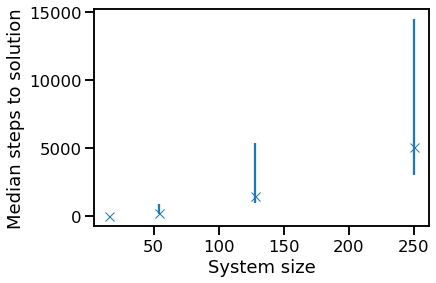

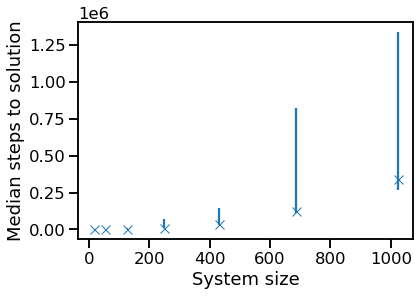

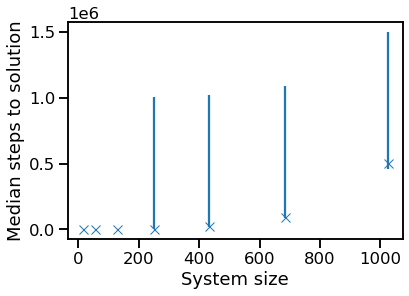

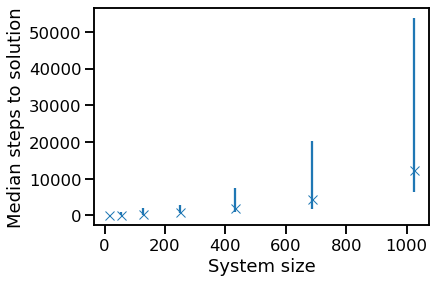

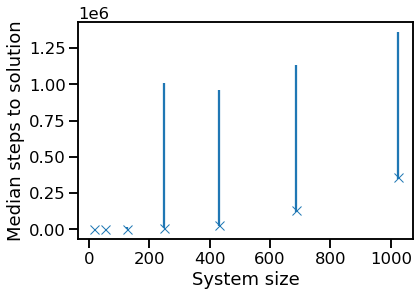

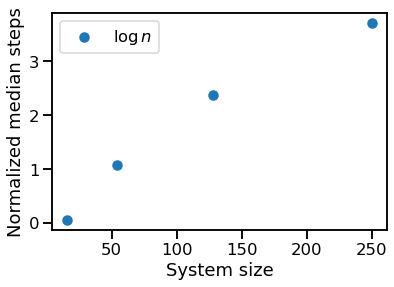

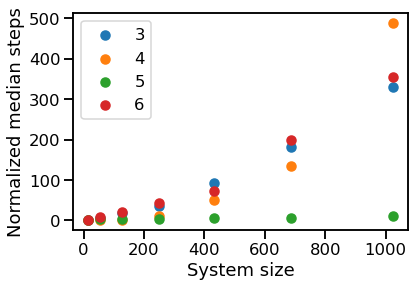

In [27]:
if PLOT:
    
    bcc_swap.plot()
    plt.show()
    for b in bcc_clusters:
        b.plot()
        plt.show()
        
    for k, v in scaling_functions.items():
        bcc_swap.plot_normalized(function=v, label=k)
        plt.show()

    fig, ax = plt.subplots()
    for i, b in enumerate(bcc_clusters):
        b.plot_normalized(ax=ax, function=None, label=i+3)
    plt.show();

In [18]:
pr.job_table()[pr.job_table().hamilton.values == 'ParallelIsing']

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
515,16095984,finished,None,chain_swap_16,/chain_swap_16,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:01.678841,2021-12-04 13:03:36.879699,35.0,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
520,16095985,finished,None,chain_swap_32,/chain_swap_32,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:01.867549,2021-12-04 13:03:41.114258,39.0,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
518,16095986,running,None,chain_swap_48,/chain_swap_48,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:02.056755,NaT,NaN,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
839,16095987,running,None,chain_swap_64,/chain_swap_64,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:02.252188,NaT,NaN,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
833,16095988,running,None,chain_swap_80,/chain_swap_80,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:02.435654,NaT,NaN,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,16096159,finished,None,bcc_cluster6_4,/bcc_cluster6_4,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:27.287736,2021-12-04 14:30:57.894787,5250.0,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
1151,16096160,finished,None,bcc_cluster6_5,/bcc_cluster6_5,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:27.490229,2021-12-04 16:35:46.173150,12738.0,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
1153,16096164,finished,None,bcc_cluster6_6,/bcc_cluster6_6,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:27.692163,2021-12-04 18:53:54.904332,21027.0,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
1144,16096165,finished,None,bcc_cluster6_7,/bcc_cluster6_7,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:27.884505,2021-12-05 05:41:40.468267,59892.0,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN


In [4]:
pr.job_table()[(pr.job_table().hamilton.values == 'ParallelIsing') * (pr.job_table().status.values != 'finished')]

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
517,16095986,running,None,chain_swap_48,/chain_swap_48,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:02.056755,NaT,NaN,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
682,16095987,running,None,chain_swap_64,/chain_swap_64,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:02.252188,NaT,NaN,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
678,16095988,running,None,chain_swap_80,/chain_swap_80,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:02.435654,NaT,NaN,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
515,16095989,running,None,chain_swap_96,/chain_swap_96,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:02.626738,NaT,NaN,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
516,16095990,running,None,chain_swap_112,/chain_swap_112,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:02.823369,NaT,NaN,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
565,16096076,running,None,hex_cluster4_12,/hex_cluster4_12,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:17.863877,NaT,NaN,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
562,16096078,running,None,hex_cluster4_14,/hex_cluster4_14,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:18.073665,NaT,NaN,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
564,16096080,running,None,hex_cluster4_16,/hex_cluster4_16,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:18.287379,NaT,NaN,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
563,16096087,running,None,hex_cluster5_8,/hex_cluster5_8,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:18.918036,NaT,NaN,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
3299,16096088,running,None,hex_cluster5_10,/hex_cluster5_10,/cmmc/ptmp/lhuber/,pyiron_ising/notebooks/scaling/,2021-12-04 13:03:19.114174,NaT,NaN,lhuber@cmti001#40#0/40,ParallelIsing,0.3,None,NaN
